In [128]:
import numpy as np
import matplotlib.pyplot as plt
import requests
from collections import Counter
from scipy.optimize import curve_fit
import re
import os

In [129]:
MAX_LONG = 20
MIN_LONG = 3
STOP_WORDS_FILE = '../stop-words.txt'
URL_QUIJOTE = "http://www.gutenberg.org/cache/epub/2000/pg2000.txt"
response = requests.get(URL_QUIJOTE)
book_content = response.text

In [130]:
def removeStopWords(words_list, stop_words_list):
    cleaned_text = [word for word in words_list if word not in stop_words_list]
    return cleaned_text

In [131]:
def findAbbreviations(content):
    REGEX_ABBREVIATIONS = r'\b[a-zA-Z][bcdfgh-np-tvxz]+(?![A-Z])\.'
    return re.findall(REGEX_ABBREVIATIONS, content)

In [132]:
def findEmailsAndUrls(content):
    REGEX_EMAILS = r'\b[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+'
    REGEX_URLS = r'(https?://)?(www\.[a-z0-9]+(?:\.[a-z0-9]+)+)'
    list_emails = re.findall(REGEX_EMAILS, content)
    list_urls = [''.join(url_tuple) for url_tuple in re.findall(REGEX_URLS, content)]
    return list_emails + list_urls

In [133]:
def findNumbersAndPhones(content):
    REGEX_NUMBERS = r' (\d+)'
    REGEX_PHONES = r'\+?\d{6,}|\+?\d{8,}|\d{2,}-\d{5,}|\+?\d+-\d{2,}-\d{5,}'
    list_numbers = re.findall(REGEX_NUMBERS, content)
    list_phones = re.findall(REGEX_PHONES, content)
    return list_phones + list_numbers

In [134]:
def findWords(content):
    REGEX_WORDS = f'[A-zÀ-ú]{{{MIN_LONG},{MAX_LONG}}}'
    return re.findall(REGEX_WORDS, content)

In [135]:
def tokenizer(content, stop_words_list = None):
    abbreviations_list = findAbbreviations(content)
    emailsAndUrls_list = findEmailsAndUrls(content)
    numbersAndPhones_list = findNumbersAndPhones(content)
    words_list = findWords(content)
    content = abbreviations_list + emailsAndUrls_list + numbersAndPhones_list + words_list
    if stop_words_list != None:
        content = removeStopWords(content, stop_words_list)
    return content

In [136]:
def loadFileStopWords(stop_words_file: str):
    complete_route = os.path.abspath(stop_words_file)
    with open(complete_route, 'r', encoding='utf-8') as file:
        stop_words = set(word.strip() for word in file.readlines())
    return stop_words

In [137]:
# Obtener la lista de términos y sus frecuencias
terms = tokenizer(book_content, loadFileStopWords(STOP_WORDS_FILE))
term_freq = Counter(terms)
sorted_term_freq = sorted(term_freq.items(), key=lambda x: x[1], reverse=True)
frequencies = [freq for term, freq in sorted_term_freq]

# Calcular el rango de los datos para el ajuste
rank = np.arange(1, len(frequencies) + 1)
# Ajustar la curva utilizando Polyfit
log_frequencies = np.log(frequencies)
log_rank = np.log(rank)
coefficients = np.polyfit(log_rank, log_frequencies, 1)
fit = np.poly1d(coefficients)

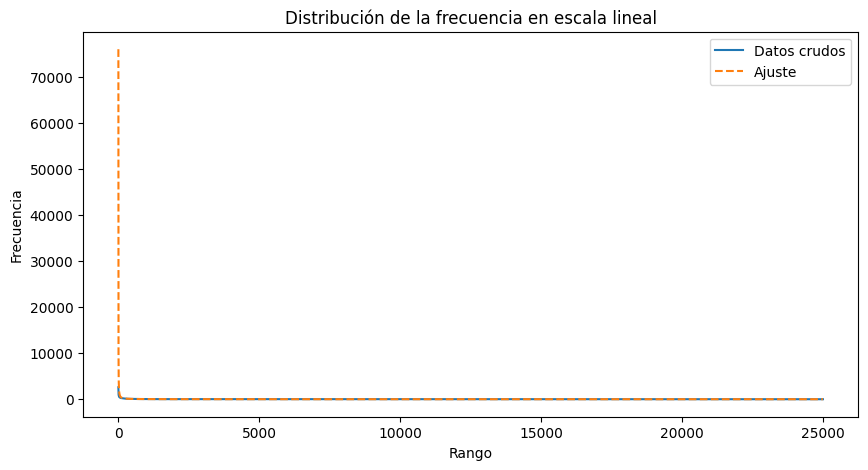

In [138]:
plt.figure(figsize=(10, 5))
plt.plot(rank, frequencies, label='Datos crudos')
plt.plot(rank, np.exp(fit(log_rank)), label='Ajuste', linestyle='--')
plt.xlabel('Rango')
plt.ylabel('Frecuencia')
plt.title('Distribución de la frecuencia en escala lineal')
plt.legend()
plt.show()

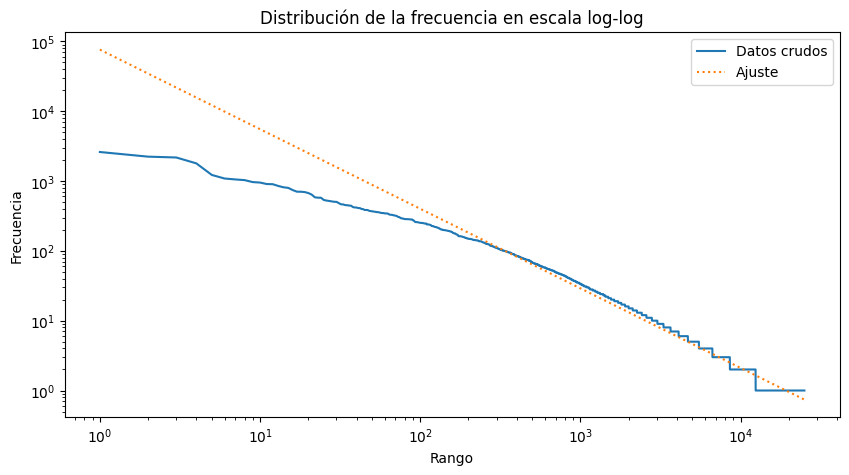

In [139]:
# Graficar los datos y el ajuste en escala log-log
plt.figure(figsize=(10, 5))
plt.loglog(rank, frequencies, label='Datos crudos')
plt.loglog(rank, np.exp(fit(log_rank)), label='Ajuste', linestyle='dotted')
plt.xlabel('Rango')
plt.ylabel('Frecuencia')
plt.title('Distribución de la frecuencia en escala log-log')
plt.legend()
plt.show()